In [ ]:
# Importing Libraries required.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples



# Load the data and inspect it

In [2]:
# Load the dataset from the CSV file
study_data= pd.read_csv('data/mental-heath-in-tech-2016_20161114.csv')

In [ ]:
# Display the columns in the dataset
for col in study_data.columns:
    print(col)

# Shorten column names

In [4]:
# Make a copy of the original colums to compare later
orig_columns = study_data.columns

# Rename the columns for better readability
study_data.columns = [
    'self_employed',
    'num_employees',
    'employer_tech_company',
    'role_related_to_tech',
    'mental_health_benefits',
    'know_mental_health_options',
    'employer_discussed_mh',
    'employer_mh_resources',
    'anonymity_protected',
    'mh_leave_comfort',
    'mh_discussion_negative',
    'ph_discussion_negative',
    'mh_comfort_coworkers',
    'mh_comfort_supervisor',
    'employer_mh_priority',
    'negative_consequences_observed',
    'medical_coverage_mh',
    'know_local_mh_resources',
    'reveal_mh_clients',
    'reveal_mh_clients_negative',
    'reveal_mh_coworkers',
    'reveal_mh_coworkers_negative',
    'productivity_affected',
    'work_time_affected_pct',
    'previous_employers',
    'prev_employers_mh_benefits',
    'prev_employers_mh_options',
    'prev_employers_discussed_mh',
    'prev_employers_mh_resources',
    'prev_employers_anonymity',
    'prev_employers_mh_negative',
    'prev_employers_ph_negative',
    'mh_comfort_prev_coworkers',
    'mh_comfort_prev_supervisor',
    'prev_employers_mh_priority',
    'prev_employers_negative_obs',
    'physical_health_in_interview',
    'physical_health_in_interview_reason',
    'mental_health_in_interview',
    'mental_health_in_interview_reason',
    'mh_hurt_career',
    'mh_viewed_negatively',
    'mh_share_friends_family',
    'unsupportive_response',
    'observed_mh_discussion_effect',
    'family_history_mh',
    'past_mh_disorder',
    'current_mh_disorder',
    'current_mh_condition',
    'maybe_mh_condition',
    'diagnosed_mh_condition',
    'diagnosed_mh_condition_details',
    'sought_mh_treatment',
    'mh_treatment_effective',
    'mh_treatment_ineffective',
    'age',
    'gender',
    'country_residence',
    'us_state_residence',
    'country_work',
    'us_state_work',
    'work_position',
    'work_remote'
]

In [ ]:
# Compare the original columns with the new columns
for i in range(len(orig_columns)):
    print(study_data.columns[i], ' <- ', orig_columns[i])

# Get a brief overview of the data

In [ ]:
# Display main statistics of each column
describe = study_data.describe(include='all').T.to_string()
print(describe)

In [ ]:
# Display all unique values of each column
for col in study_data.columns:
    print('\n',study_data[col].value_counts(), '\n')

# Data cleaning

## Remove answers with no informations

In [8]:
# Removing uncertain answers  
study_data = study_data.replace('Not applicable to me',np.nan)
study_data = study_data.replace('I don\'t know',np.nan)
study_data = study_data.replace('I\'m not sure',np.nan)
study_data = study_data.replace('N/A (not currently aware)',np.nan)
study_data = study_data.replace('Not eligible for coverage / N/A',np.nan)
study_data = study_data.replace('Not applicable to me (I do not have a mental illness)', np.nan)

## Unify country names

In [9]:
# Define a mapping for replacement
country_mapping = {
    'United States of America': 'USA',
    'United Kingdom': 'UK'
}

# Replace values in both 'country_live' and 'country_work' columns
study_data[['country_residence', 'country_work']] = study_data[['country_residence', 'country_work']].replace(country_mapping)

## Drop redundant and unecessary features

In [10]:
# Check where county_work is different from country_residence
i = 0
for index, row in study_data.iterrows():
    if row['country_residence'] != row['country_work']:
        print(row['country_residence'], ' -> ', row['country_work'])
        i += 1

print('\nTotal number of people having different work than residence countries: ', i/index*100, '%')

USA  ->  United Arab Emirates
Spain  ->  USA
Canada  ->  USA
UK  ->  USA
USA  ->  Turkey
Canada  ->  USA
Canada  ->  USA
Netherlands  ->  UK
Lithuania  ->  UK
Algeria  ->  USA
Pakistan  ->  USA
Australia  ->  Other
UK  ->  USA
Other  ->  Germany
Romania  ->  USA
Japan  ->  Canada
France  ->  UK
Canada  ->  USA
France  ->  UK
Germany  ->  UK
Italy  ->  USA
Italy  ->  Sweden
Taiwan  ->  USA
Afghanistan  ->  USA
Canada  ->  USA
USA  ->  Afghanistan

Total number of people having different work than residence countries:  1.8156424581005588 %



#### Drop country_residence, us_state_residence, us_state_work because the information is not relevant for the topic

In [11]:
study_data.drop(columns=['country_residence'], inplace=True)    # Drop the country_residence column
study_data.drop(columns=['us_state_residence'], inplace=True)   # Drop the us_state_residence column
study_data.drop(columns=['us_state_work'], inplace=True)        # Drop the us_state_work column

## Find and drop coulums with contextual answers

In [ ]:
# find columns with strings greater than 10 characters
for col in study_data.columns:
    if study_data[col].dtype == 'object':
        if study_data[col].str.len().max() > 10:
            print('\n',study_data[col].value_counts(), '\n')

In [13]:
# Drop the columns with contextual data
study_data.drop(columns=['physical_health_in_interview_reason'], inplace=True)
study_data.drop(columns=['mental_health_in_interview_reason'], inplace=True)


## Replace age outliers

In [14]:
print(np.sort(study_data['age'].unique()))       # Display unique age values

[  3  15  17  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  61  62  63  65  66  70  74  99 323]


In [15]:
age_copy = study_data['age'].copy()                     # Create a copy for later comparison
study_data['age'] = study_data['age'].apply(
    lambda x: np.nan if x < 18 or x > 75 else x         # Replace age outliers with NaN
    )
age_checksum = (study_data['age'] != age_copy).sum()    # Check how many rows were changed

print(f'Replaced age outliers with NaN for {age_checksum} rows.')

Replaced age outliers with NaN for 5 rows.


## Fill missing age values

In [16]:
age_copy_2 = study_data['age'].copy()                       # Create a copy for later comparison
age_median = study_data['age'].median()                     # Calculate the median age
study_data.fillna({'age': age_median}, inplace=True)        # Fill missing age values with the median
age_checksum_2 = (age_copy_2 != study_data['age']).sum()    # Check how many rows were changed

print(f'Filled missing age values with the median: {age_median}  for {age_checksum_2} rows.')

Filled missing age values with the median: 33.0  for 5 rows.


## Reduce age to categories

In [17]:
study_data['age'] = pd.cut(
    study_data['age'], 
    bins=[18, 30, 40, 50, 60, float('inf')],  # Extend bins to include all ages above 60
    labels=['18-30', '30-40', '40-50', '50-60', '60+'], 
    right=False
)
print(study_data['age'].value_counts())

age
30-40    683
18-30    447
40-50    235
50-60     57
60+       11
Name: count, dtype: int64


## Replace company size 

In [18]:
study_data['num_employees'] = study_data['num_employees'].replace('More than 1000', '1000+')

## Drop rows with too many missing values


In [19]:
original_count = study_data.shape[0]                                            # Get the original row count
study_data = study_data.dropna(thresh=study_data.shape[1] * 0.65)               # Drop rows with over 35% missing values
drop_lines_percent = (1 - (study_data.shape[0] / original_count)) *100          # Calculate the percentage of dropped rows

print(f'Dropped {drop_lines_percent}% of rows due to missing values.')

Dropped 32.17027215631543% of rows due to missing values.


## Drop columns with to many missing values

#### Get an overview of the nan percentage in the columns

In [20]:
# Calculate NaN percentages
nan_percentage = (study_data.isna().sum() / len(study_data)) * 100
# Sort by percentage in descending order
nan_percentage_sorted = nan_percentage.sort_values(ascending=False)

# Display the sorted percentages
print(nan_percentage_sorted.to_string())

reveal_mh_clients_negative        94.753086
reveal_mh_coworkers_negative      94.238683
work_time_affected_pct            90.740741
reveal_mh_coworkers               90.226337
reveal_mh_clients                 90.020576
medical_coverage_mh               89.917695
productivity_affected             89.917695
know_local_mh_resources           89.917695
role_related_to_tech              79.320988
maybe_mh_condition                77.674897
anonymity_protected               65.637860
prev_employers_anonymity          61.213992
current_mh_condition              50.823045
observed_mh_discussion_effect     45.370370
employer_mh_priority              45.061728
diagnosed_mh_condition_details    39.094650
prev_employers_mh_options         38.168724
mental_health_benefits            37.037037
employer_mh_resources             31.790123
mh_treatment_effective            27.160494
mh_treatment_ineffective          21.193416
mh_leave_comfort                  20.267490
know_mental_health_options      

#### Drop columns with more than 50% of missing values

In [21]:
for col_name, percentage in nan_percentage_sorted.items():         # Iterate over the sorted percentages 
    if percentage > 50:                                            # If the percentage is over 30%
        study_data.drop(col_name, axis=1, inplace=True)            # Drop the column from study_data

#### Check for missing values percentage again

In [ ]:
nan_percentage = (study_data.isna().sum() / len(study_data)) * 100  # Recalculate NaN percentages
nan_percentage_sorted = nan_percentage.sort_values(ascending=False) # Sort by percentage in descending order

print(nan_percentage_sorted.to_string())                            # Display the sorted percentages

## Replace genders

In [23]:
# Define gender categories with a dictionary for efficient replacement
gender_map = {
    **{key: 'male' for key in ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 
                               'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male',
                               'cis male', 'Malr', 'Dude', 
                               'I\'m a man why didn\'t you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ',
                               'mail', 'M|', 'Male/genderqueer', 'male ', 'Cis Male', 
                               'Male (trans, FtM)', 'cisdude', 'cis man', 'MALE']},
                               
    **{key: 'female' for key in ['Female', 'female', 'I identify as female.', 'female ', 
                                 'Female assigned at birth ',
                                 'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
                                 'Genderfluid (born female)', 'Female or Multi-Gender Femme', 
                                 'Female ', 'woman', 'female/woman', 'Cisgender Female', 'fem', 
                                 'Female (props for making this a freeform field, though)', 
                                 ' Female', 'Cis-woman', 'female-bodied; no feelings about gender',
                                 'AFAB']}
}

# Store initial gender value counts
gender_before = study_data['gender'].value_counts()

# Replace genders using the map and set all non-male/female values to 1
study_data['gender'] = study_data['gender'].replace(gender_map).apply(
    lambda x: 'queer' if x not in ['male', 'female'] else x
    )

# Display results
print('Before:\n', gender_before, '\n\n\nAfter:\n', study_data['gender'].value_counts())

Before:
 gender
Male                                                                                                                                                             417
male                                                                                                                                                             155
Female                                                                                                                                                           112
female                                                                                                                                                            75
M                                                                                                                                                                 57
m                                                                                                                                                              

## Replace answers in 'mh_hurt_career', 'mh_viewed_negatively', 'mh_share_friends_family','unsupportive_response'

In [24]:
# Define gender categories with a dictionary for efficient replacement
answer_map = {
    **{key: 'Yes' for key in ['Yes, I think it would', 'Yes, it has', 'Yes, I think they would',
                                'Yes, they do', 'Somewhat open', 'Very open',
                                'Yes', 'Yes, I observed', 'Yes, I experienced']},
                               
    **{key: 'Maybe' for key in ['Maybe', 'Neutral', 'Maybe/Not sure']},

    **{key: 'No' for key in ['No, it has not', 'No, I don\'t think it would',
                             'No, they do not','No, I don\'t think they would',
                             'Not open at all', 'Somewhat not open']}
}

# Make a list of columns to replace
columns_to_replace = ['mh_hurt_career', 'mh_viewed_negatively', 'mh_share_friends_family', 'unsupportive_response']

# Replace genders using the map and set all non-male/female values to 1
for column in columns_to_replace:
    study_data[column] = study_data[column].replace(answer_map)

# Display results
for column in columns_to_replace:
    print(study_data[column].value_counts(), '\n')

mh_hurt_career
Yes      471
Maybe    378
No       123
Name: count, dtype: int64 

mh_viewed_negatively
Maybe    385
Yes      311
No       276
Name: count, dtype: int64 

mh_share_friends_family
Yes      653
No       205
Maybe     83
Name: count, dtype: int64 

unsupportive_response
Yes      352
No       350
Maybe    248
Name: count, dtype: int64 



## Reducing countries of work

In [ ]:
# Get the unique values of the 'country_work' column
print(study_data['country_work'].value_counts())

In [26]:
# Define the continent mappings
continent_mapping = {
    **{country: 'north_america' for country in ['United States of America', 'Canada', 'Mexico']},
    **{country: 'europe' for country in [
        'United Kingdom', 'Netherlands', 'Germany', 'Sweden', 'France',
        'Ireland', 'Switzerland', 'Bulgaria', 'Finland', 'Denmark',
        'Russia', 'Spain', 'Norway', 'Austria', 'Bosnia and Herzegovina',
        'Italy', 'Poland', 'Belgium', 'Czech Republic']},
}

# Replace the values in 'country_work' column with the mapped values or 'Other'
study_data['country_work'] = study_data['country_work'].apply(lambda x: continent_mapping.get(x, 'Other'))

# Display the unique values of the 'country_work' column
print(study_data['country_work'].value_counts())

country_work
Other            803
europe           119
north_america     50
Name: count, dtype: int64


## Reducing work position


In [ ]:
# Get the unique values of the 'work_position' column
print(study_data['work_position'].value_counts().to_string())

In [28]:
# Optimized category mapping with direct keyword-to-category association
keyword_to_category = {
    'supervisor': 'Management',
    'team lead': 'Management',
    'leadership': 'Management',
    'executive': 'Management',
    'back': 'Development',
    'developer': 'Development',
    'front': 'Development',
    'devops': 'Development',
    'sysadmin': 'Development',
    'dev': 'Development',
}

# Function to classify roles
def categorize_role_optimized(role):
    role = role.lower()  # Standardize to lowercase
    for keyword, category in keyword_to_category.items():
        if keyword in role:
            return category
    return 'Other'  # Default for unmatched roles

# Convert the entire column to lowercase for efficiency
study_data['work_position'] = study_data['work_position'].str.lower()

# Apply the optimized categorization function
study_data['work_position'] = study_data['work_position'].apply(categorize_role_optimized)

# Display the unique values and their counts
print(study_data['work_position'].value_counts().to_string())

work_position
Development    565
Management     246
Other          161


## Display all unique values for each column

In [ ]:
for col in study_data.columns:
    print('\n\n', study_data[col].value_counts().to_string(), '\n\n')

## Encode the  diagnosed_mh_condition_details column

In [30]:
# Create a set to store the individual values
unique_values = set()

# Iterate over the rows and save the unique strings split at '|'
for value in study_data['diagnosed_mh_condition_details']:
    if pd.notna(value):
        unique_values.update(value.split('|'))

# Display the unique values
print('\n'.join(unique_values))

Attention Deficit Hyperactivity Disorder
Depression
attention deficit disorder (but not the hyperactive version)
Addictive Disorder
Obsessive-Compulsive Disorder
Aspergers
ADD (w/o Hyperactivity)
Eating Disorder (Anorexia, Bulimia, etc)
Suicidal Ideation
Personality Disorder (Borderline, Antisocial, Paranoid, etc)
Dissociative Disorder
posttraumatic stress disourder
Intimate Disorder
MCD (when it was diagnosed, the ultra-mega "disorder" ADHD didn't exist yet)
Autism
Autism - while not a "mental illness", still greatly affects how I handle anxiety
Substance Use Disorder
Gender Identity Disorder
Stress Response Syndromes
Seasonal Affective Disorder
Gender Dysphoria
Post-traumatic Stress Disorder
Attention Deficit Disorder
Asperger Syndrome
Mood Disorder (Depression, Bipolar Disorder, etc)
Autism (Asperger's)
Psychotic Disorder (Schizophrenia, Schizoaffective, etc)
Anxiety Disorder (Generalized, Social, Phobia, etc)
Autism Spectrum Disorder


In [31]:
# Iterate over the rows and split at '|'
study_data['diagnosed_mh_condition_details'] = study_data['diagnosed_mh_condition_details'].apply(
    lambda x: x.split('|') if pd.notna(x) else x
)

In [32]:
# Define the mapping of disorders to categories
disorder_category_mapping = {
    # Mood Disorders
    'Depression': 'Mood Disorders',
    'Seasonal Affective Disorder': 'Mood Disorders',
    'Mood Disorder (Depression, Bipolar Disorder, etc)': 'Mood Disorders',
    'Suicidal Ideation': 'Mood Disorders',
    'Intimate Disorder': 'Mood Disorders',

    # Anxiety and Stress-Related Disorders
    'Anxiety Disorder (Generalized, Social, Phobia, etc)': 'Anxiety and Stress-Related Disorders',
    'Post-traumatic Stress Disorder': 'Anxiety and Stress-Related Disorders',
    'Stress Response Syndromes': 'Anxiety and Stress-Related Disorders',
    'Obsessive-Compulsive Disorder': 'Anxiety and Stress-Related Disorders',
    'Gender Identity Disorder': 'Anxiety and Stress-Related Disorders',
     'posttraumatic stress disourder': 'Anxiety and Stress-Related Disorders',

    # Other
    'Attention Deficit Hyperactivity Disorder': 'Other',
    'ADD (w/o Hyperactivity)': 'Other',
    'Attention Deficit Disorder': 'Other',
    'MCD (when it was diagnosed, the ultra-mega \'disorder\' ADHD didn\'t exist yet)': 'Other',
    'Autism Spectrum Disorder': 'Other',
    'Autism': 'Other',
    'Autism - while not a \'mental illness\', still greatly affects how I handle anxiety': 'Other',
    'Asperger Syndrome': 'Other',
    'Aspergers': 'Other',
    'Personality Disorder (Borderline, Antisocial, Paranoid, etc)': 'Other',
    'Gender Dysphoria': 'Other',
    'Eating Disorder (Anorexia, Bulimia, etc)': 'Other',
    'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)': 'Other',
    'Dissociative Disorder': 'Other',
    'Substance Use Disorder': 'Other',
    'Addictive Disorder': 'Other',
}

# Function to map disorders to categories
def map_disorders_to_categories(disorder_list):
    if isinstance(disorder_list, list):  # Check if the input is a list
        mapped_categories = []  # Initialize an empty list
        for item in disorder_list:  # Iterate over the list
            mapped_categories.append(disorder_category_mapping.get(item, 'Other'))  # Map the disorder to a category
        return mapped_categories    # Return the list of categories
    else:
        return disorder_list  # Return as-is if not a list
    
# Apply the mapping to the DataFrame
study_data['diagnosed_mh_condition_details'] = study_data['diagnosed_mh_condition_details'].apply(map_disorders_to_categories)

# Take the mode of each row in the 'diagnosed_mh_condition_details' column
study_data['diagnosed_mh_condition_details'] = study_data['diagnosed_mh_condition_details'].apply(
    lambda x: max(set(x), key=x.count) if isinstance(x, list) else x
)


In [33]:
# Check the unique values in the column
print(study_data['diagnosed_mh_condition_details'].value_counts())

diagnosed_mh_condition_details
Mood Disorders                          384
Anxiety and Stress-Related Disorders    126
Other                                    82
Name: count, dtype: int64


# Impute missing values

## Get an overview of the missing data

In [ ]:
# Display the missing value counts for each column and the most frequent value
for col in study_data.columns:
    print(f'\n{col}:')
    print('Number of missing values: ', study_data[col].isna().sum())
    print('Most frequent value:      ', study_data[col].mode().values[0])

## Use resample to impute the missing data based on the proportion of the existing data to preserve variance

In [35]:
# Loop through the columns and replace missing values with the most frequent value
for col in study_data.columns:
  
    # Replace missing values statistical most likely value
    missing = study_data[col].isnull()
    probs = study_data[col].value_counts(normalize=True)
    study_data.loc[missing, col] = np.random.choice(probs.index, size=len(study_data[missing]), p=probs.values)

#### Check if inputing was successful

In [36]:
# Create a check variable
check = True

# Check if there are any missing values left
for col in study_data.columns:
    if study_data[col].isna().sum() > 0:
        print(col)
    else:
        check = False

# If there are no missing values left, display a message
if not check:
    print('No missing values left.')

No missing values left.


#### Final data shape

In [37]:
study_data.shape

(972, 45)

## Save the final data set to .csv

In [38]:
# Save to a new CSV file
study_data.to_csv('data/prep_data.csv', index=False)

# Encoding

## Define column encoding types and ordinal mapping

In [39]:
# Select columns based on types
numerical_cols = [
    'employer_tech_company', 
    'self_employed', 
    'sought_mh_treatment', 
    'previous_employers'
]

# All columns with defined ordinal mapping
ordinal_cols = [
    'num_employees',
    'mental_health_benefits',
    'know_mental_health_options',
    'employer_discussed_mh',
    'employer_mh_resources',
    'mh_leave_comfort',
    'mh_discussion_negative',
    'ph_discussion_negative',
    'mh_comfort_coworkers',
    'mh_comfort_supervisor',
    'employer_mh_priority',
    'negative_consequences_observed',
    'prev_employers_mh_benefits',
    'prev_employers_mh_options',
    'prev_employers_discussed_mh',
    'prev_employers_mh_resources',
    'prev_employers_mh_negative',
    'prev_employers_ph_negative',
    'mh_comfort_prev_coworkers',
    'mh_comfort_prev_supervisor',
    'prev_employers_mh_priority',
    'prev_employers_negative_obs',
    'physical_health_in_interview',
    'mental_health_in_interview',
    'mh_hurt_career',
    'mh_viewed_negatively',
    'mh_share_friends_family',
    'unsupportive_response',
    'observed_mh_discussion_effect',
    'family_history_mh',
    'past_mh_disorder',
    'current_mh_disorder',
    'diagnosed_mh_condition',
    'mh_treatment_effective',
    'mh_treatment_ineffective',
    'age',
    'gender',
    'work_remote'
]

# Remaining categorical columns (excluding ordinal columns)
categorical_cols = [
    'country_work', 
    'work_position',
    'diagnosed_mh_condition_details'
]

# Define the column transformer
ordinal_mapping = {
    'num_employees': ['1-5', '6-25', '26-100', '100-500', '500-1000', '1000+'],
    'mental_health_benefits': ['No', 'Yes'],
    'know_mental_health_options': ['No', 'I am not sure', 'Yes'],
    'employer_discussed_mh': ['No', 'Maybe', 'Yes'],
    'employer_mh_resources': ['No', 'Some', 'Yes'],
    'mh_leave_comfort': ['Very difficult', 'Somewhat difficult',  'Neither easy nor difficult', 'Somewhat easy', 'Very easy'],
    'mh_discussion_negative': ['No', 'Maybe', 'Yes'],
    'ph_discussion_negative': ['No', 'Maybe', 'Yes'],
    'mh_comfort_coworkers': ['No', 'Maybe', 'Yes'],
    'mh_comfort_supervisor': ['No', 'Maybe', 'Yes'],
    'employer_mh_priority': ['No', 'Somewhat', 'Yes'],
    'negative_consequences_observed': ['No', 'Maybe', 'Yes'],
    'prev_employers_mh_benefits': ['No, none did', 'Some did', 'Yes, they all did'],
    'prev_employers_mh_options': ['No, I only became aware later', 'I was aware of some', 'Yes, I was aware of all of them'],
    'prev_employers_discussed_mh': ['None did', 'Some did', 'Yes, they all did'],
    'prev_employers_mh_resources': ['None did', 'Some did', 'Yes, they all did'],
    'prev_employers_mh_negative': ['None of them', 'Some of them', 'Yes, all of them'],
    'prev_employers_ph_negative': ['None of them', 'Some of them', 'Yes, all of them'],
    'mh_comfort_prev_coworkers': ['No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'mh_comfort_prev_supervisor': ['No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'prev_employers_mh_priority': ['None did', 'Some did', 'Yes, they all did'],
    'prev_employers_negative_obs': ['None of them', 'Some of them', 'Yes, all of them'],
    'physical_health_in_interview': ['No', 'Maybe', 'Yes'],
    'mental_health_in_interview': ['No', 'Maybe', 'Yes'],
    'mh_hurt_career': ['No', 'Maybe', 'Yes'],
    'mh_viewed_negatively': ['No', 'Maybe','Yes'],
    'mh_share_friends_family': ['No', 'Maybe', 'Yes'],
    'unsupportive_response': ['No', 'Maybe', 'Yes'],
    'observed_mh_discussion_effect': ['No', 'Maybe', 'Yes'],
    'family_history_mh': ['No', 'Yes'],
    'past_mh_disorder': ['No', 'Maybe', 'Yes'],
    'current_mh_disorder': ['No', 'Maybe', 'Yes'],
    'diagnosed_mh_condition': ['No', 'Yes'],
    'mh_treatment_effective': ['Never', 'Rarely', 'Sometimes', 'Often'],
    'mh_treatment_ineffective': ['Never', 'Rarely', 'Sometimes', 'Often'],
    'age': ['18-30', '30-40', '40-50', '50-60', '60+'],
    'gender': ['male', 'female', 'queer'],
    'work_remote': ['Never', 'Sometimes', 'Always']
}

In [40]:
# Check if ordinal mapping is correct
for col in study_data.columns:
    for val in study_data[col].unique():
        if col in ordinal_mapping and val not in ordinal_mapping[col]:
            print(col, '-->', val)


# Check if all ordinal columns are in the ordinal mapping
for col in ordinal_cols:
    if col not in ordinal_mapping:
        print(col)


# Check if all categorical columns are in the ordinal mapping
check_list = numerical_cols + ordinal_cols + categorical_cols
for col in study_data.columns:
    if col not in check_list:
        print(col)

## Fit the encoding

In [41]:
# Get a copy of the preprqocessed data
data = study_data.copy()

# Ordinal Encoder for specific columns
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_cols])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('ord', ordinal_encoder, ordinal_cols)
    ]
)

# Fit-transform the data
processed_data = preprocessor.fit_transform(data)

# Resulting processed data is ready for clustering
print(processed_data.shape)

# Scale the data
scaler = StandardScaler()
processed_data = scaler.fit_transform(processed_data)

# Convert data to DataFrame
processed_data = pd.DataFrame(processed_data, columns=preprocessor.get_feature_names_out())


# Save encoded data to a new CSV file
processed_data.to_csv('data/encoded_data.csv', index=False)

(972, 48)


# Dimensionality reduction

## t-SNE for visualisation

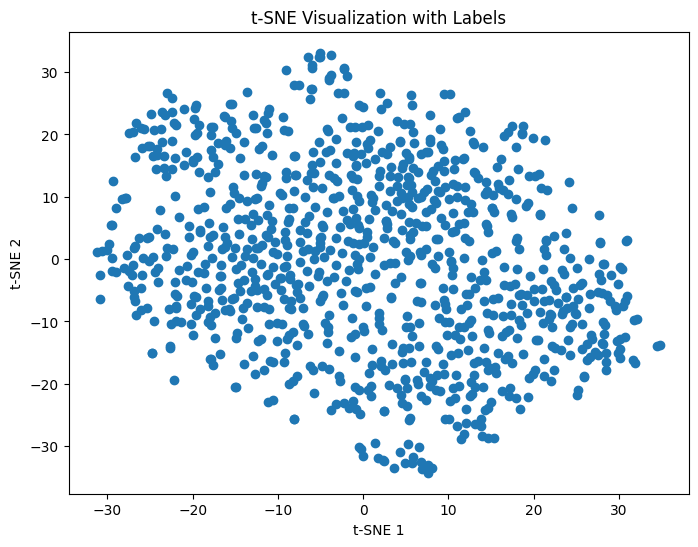

In [42]:
# Reducing the dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(processed_data)

# Visualize with labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig(f'data/plot_images/Vizualize_tSNE_2D.png', bbox_inches='tight')
plt.show()

## UMAP for clustering

/Users/lau/Documents/UNI/3. Semester/Machine Learning - Unsupervised Learning and Feature Engineering/Code/jupyter project/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


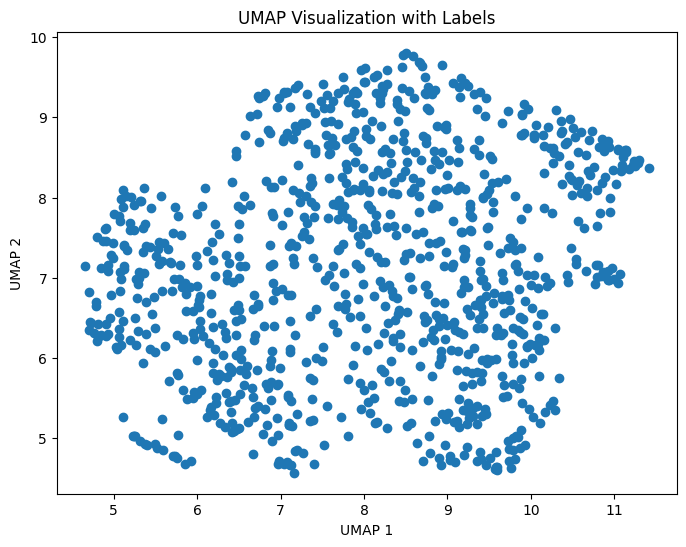

In [43]:

# Reducing dimensionality using UMAP
umap_model = UMAP(n_components=2)
umap_data = umap_model.fit_transform(processed_data)

# Visualize with labels
plt.figure(figsize=(8, 6))
plt.scatter(umap_data[:, 0], umap_data[:, 1])
plt.title('UMAP Visualization with Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig(f'data/plot_images/Vizualize_UMAP_2D.png', bbox_inches='tight')
plt.show()

# Clustering

## K-Means

#### Plot an ellbow curve to find the optimal number of clusters

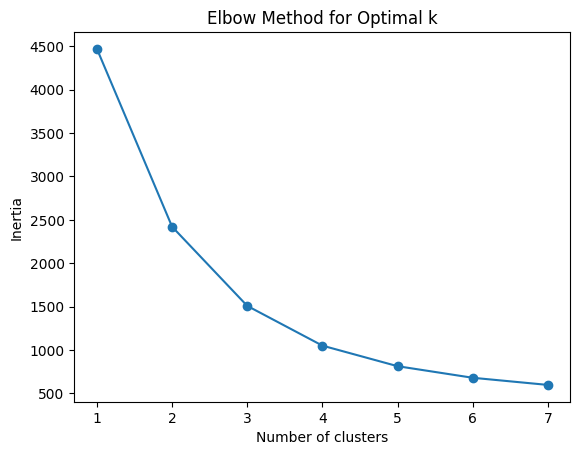

In [44]:
# Create a copy of the data for clustering
kmeans_data = umap_data.copy()

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 8) 

# Fit KMeans for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans with k clusters
    kmeans.fit(kmeans_data)                         # Fit the model
    inertia.append(kmeans.inertia_)                 # Append the inertia to the list

# Plot the Elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig(f'data/plot_images/KMeans_elbow_curve.png', bbox_inches='tight')
plt.show()

#### Perform K-Means clustering

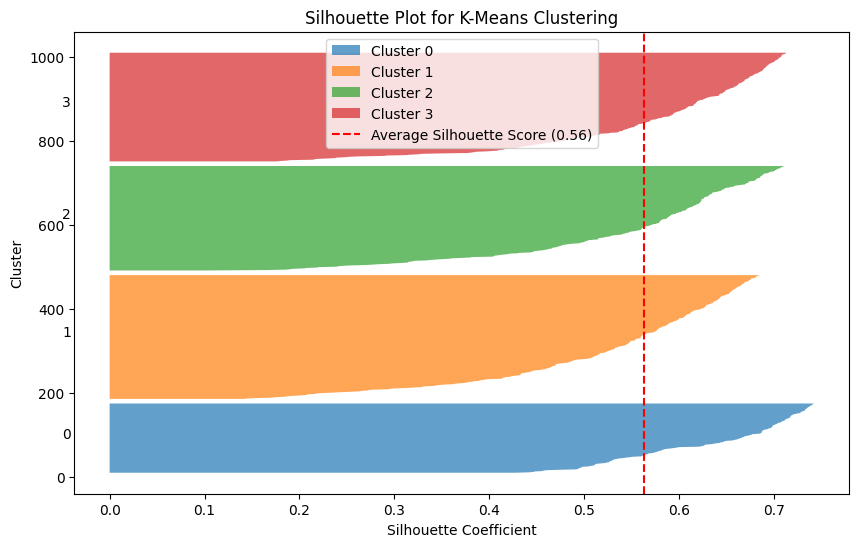

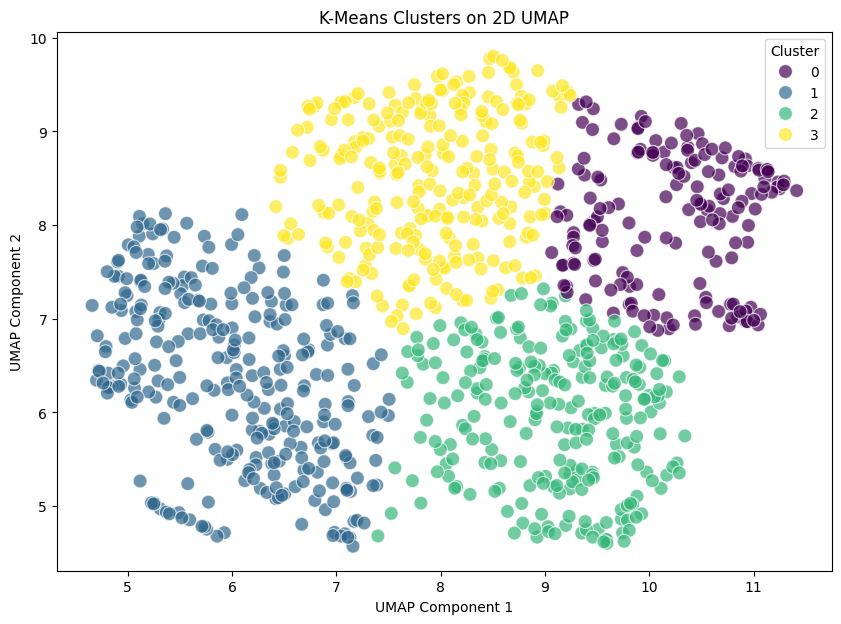

In [45]:
# Optimal number of clusters from the Elbow Method
optimal_k = 4

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, n_init=5000, random_state=42)
cluster_labels = kmeans.fit_predict(kmeans_data)

# Remap the encoded columns to their original values
kmeans_data = pd.DataFrame(kmeans_data)

# Attach the cluster labels to the original data
kmeans_data['Cluster'] = cluster_labels

# Save the data with clusters for further exploration
kmeans_save_data = processed_data.copy()                               # Create a copy of the processed data
kmeans_save_data = scaler.inverse_transform(kmeans_save_data)                 # Inverse transform the scaled data
kmeans_save_data = np.round(kmeans_save_data, 2)                              # Round the values to 2 decimal places
kmeans_save_data = pd.DataFrame(kmeans_save_data, columns=preprocessor.get_feature_names_out())   # Convert to DataFrame
kmeans_save_data['Cluster'] = cluster_labels                           # Add the cluster labels
kmeans_save_data.to_csv('data/kmeans_data.csv', index=False)           # Save the data to a new CSV file

# Calculate the silhouette scores for each sample
silhouette_vals = silhouette_samples(kmeans_data, cluster_labels)

# Get the average silhouette score
avg_score = silhouette_score(kmeans_data, cluster_labels)

# Number of clusters
n_clusters = len(np.unique(cluster_labels))

# Create a silhouette plot 
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10  # Starting position for silhouette plots

for i in range(n_clusters):
    # Get silhouette scores for samples in this cluster
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()  # Sort values for cleaner plotting
    
    # Determine the y_upper position
    y_upper = y_lower + len(cluster_silhouette_vals)
    
    # Fill the silhouette scores for this cluster
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, label=f'Cluster {i}')
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))  # Add cluster label
    y_lower = y_upper + 10  # 10 for spacing between clusters

# Draw a vertical line for the average silhouette score
ax.axvline(x=avg_score, color='red', linestyle='--', label=f'Average Silhouette Score ({avg_score:.2f})')

# Add labels and title
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for K-Means Clustering')
ax.legend(loc='best')
plt.savefig(f'data/plot_images/KMeans_Silouette_score.png', bbox_inches='tight')
plt.show()

# 2D Visualise clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('K-Means Clusters on 2D UMAP')
plt.legend(title='Cluster')
plt.savefig(f'data/plot_images/KMeans_UMAP_2D.png', bbox_inches='tight')
plt.show()


## Gaussian mixture models

#### Generate a Elbow Curve (BIC/AIC) to get the optimal number of clusters

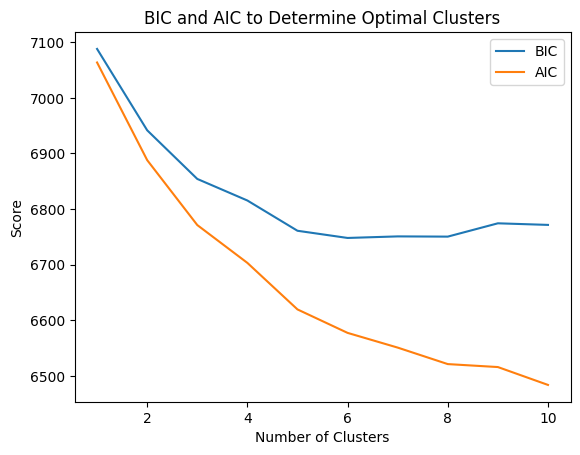

In [46]:
# Create a copy of the original data
gmm_data = umap_data.copy()

# Determine the optimal number of clusters using BIC and AIC
bic = []
aic = []
n_components_range = range(1, 11)  # Test 1 to 10 clusters

# Fit GMM with different numbers of components
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, n_init=200, random_state=42)
    gmm.fit(gmm_data)
    bic.append(gmm.bic(gmm_data))   # Calculate BIC
    aic.append(gmm.aic(gmm_data))   # Calculate AIC

# Plot BIC and AIC
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC to Determine Optimal Clusters')
plt.legend()
plt.savefig(f'data/plot_images/GMM_BIC_AIC_curve.png', bbox_inches='tight')
plt.show()

## Perform GMM Clustering

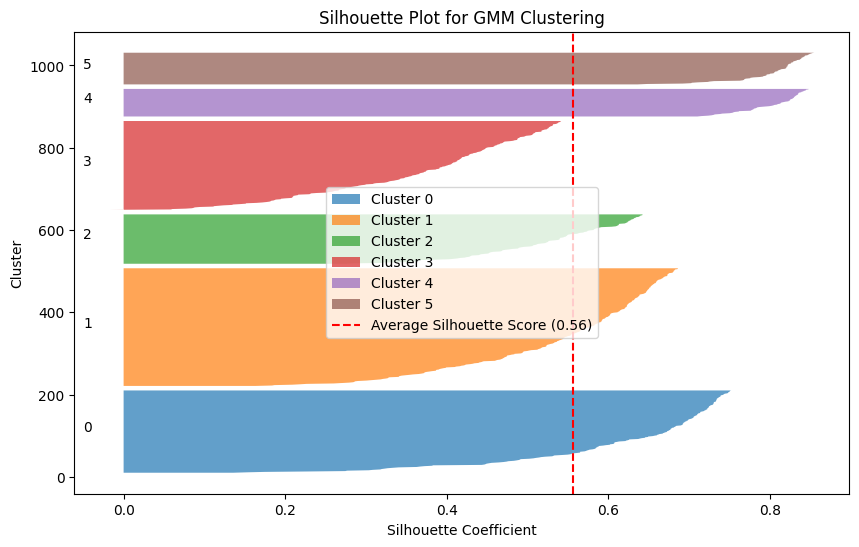

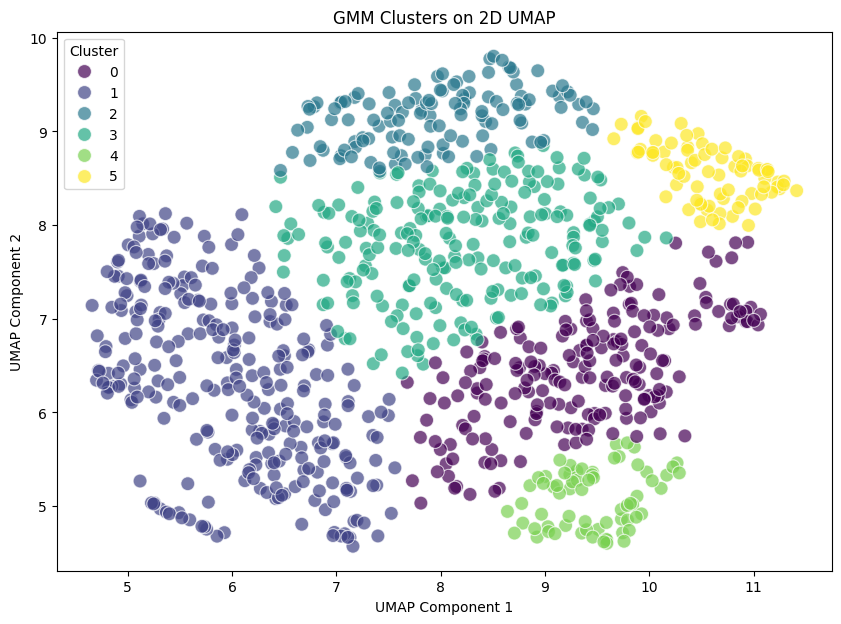

In [47]:
# Choose the optimal number of clusters from the BIC/AIC plot
optimal_n_components = 6

# Fit the GMM
gmm = GaussianMixture(n_components=optimal_n_components,n_init= 100, random_state=42, covariance_type='full')
gmm.fit(gmm_data)

# Predict cluster labels
cluster_labels = gmm.predict(gmm_data)

# Get cluster probabilities
cluster_probabilities = gmm.predict_proba(gmm_data)

# Transform to dataframe
gmm_data = pd.DataFrame(gmm_data)

# Attach cluster labels to the original data
gmm_data['Cluster'] = cluster_labels

# Save the data with clusters for further exploration
gmm_save_data = processed_data.copy()                               # Create a copy of the processed data
gmm_save_data = scaler.inverse_transform(gmm_save_data)                 # Inverse transform the scaled data
gmm_save_data = np.round(gmm_save_data, 2)                              # Round the values to 2 decimal places
gmm_save_data = pd.DataFrame(gmm_save_data, columns=preprocessor.get_feature_names_out())   # Convert to DataFrame
gmm_save_data['Cluster'] = cluster_labels                           # Add the cluster labels
gmm_save_data.to_csv('data/kmeans_data.csv', index=False)           # Save the data to a new CSV file

# Calculate the silhouette scores for each sample
silhouette_vals = silhouette_samples(gmm_data, cluster_labels)

# Get the average silhouette score
avg_score = silhouette_score(gmm_data, cluster_labels)

# Number of clusters
n_clusters = len(np.unique(cluster_labels))

# Create a silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10  # Starting position for silhouette plots

for i in range(n_clusters):
    # Get silhouette scores for samples in this cluster
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()  # Sort values for cleaner plotting
    
    # Determine the y_upper position
    y_upper = y_lower + len(cluster_silhouette_vals)
    
    # Fill the silhouette scores for this cluster
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, label=f'Cluster {i}')
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))  # Add cluster label
    y_lower = y_upper + 10  # 10 for spacing between clusters

# Draw a vertical line for the average silhouette score
ax.axvline(x=avg_score, color='red', linestyle='--', label=f'Average Silhouette Score ({avg_score:.2f})')

# Add labels and title
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for GMM Clustering')
ax.legend(loc='best')
plt.savefig(f'data/plot_images/GMM_Silhouette_score.png', bbox_inches='tight')
plt.show()

# 2D Visualise clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('GMM Clusters on 2D UMAP')
plt.legend(title='Cluster')
plt.savefig(f'data/plot_images/GMM_UMAP_2D.png', bbox_inches='tight')
plt.show()


# Statistical analysis of the data 

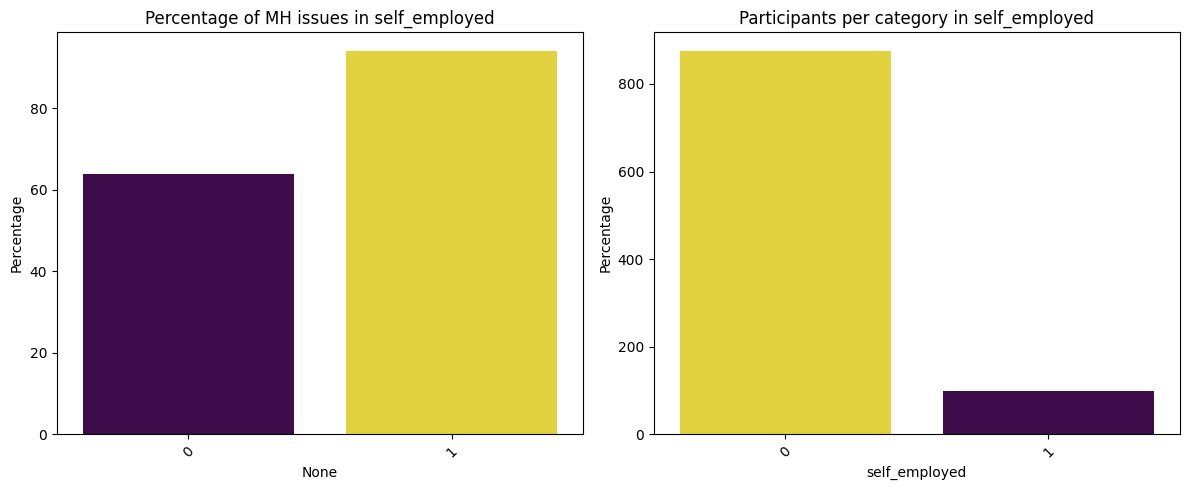

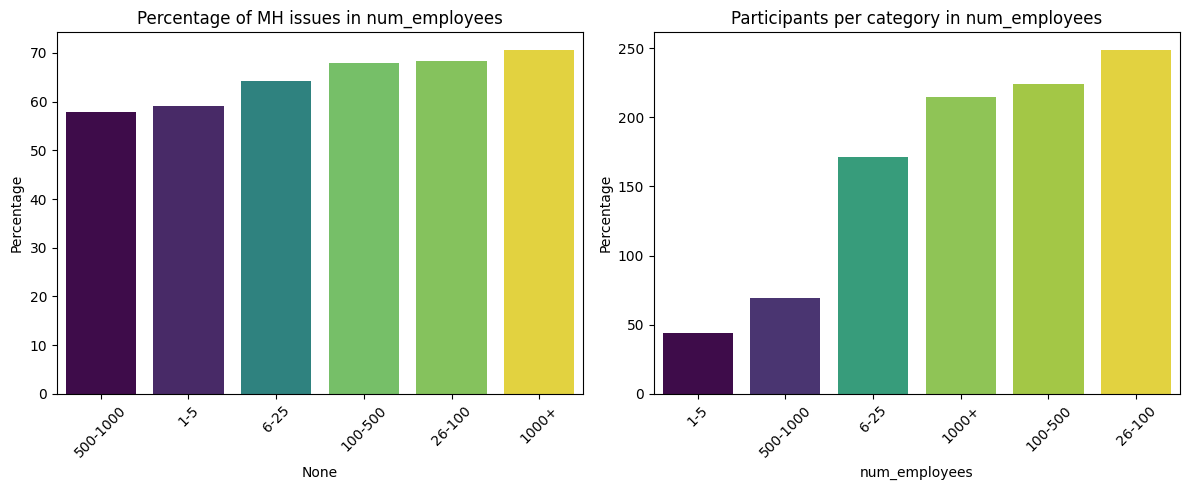

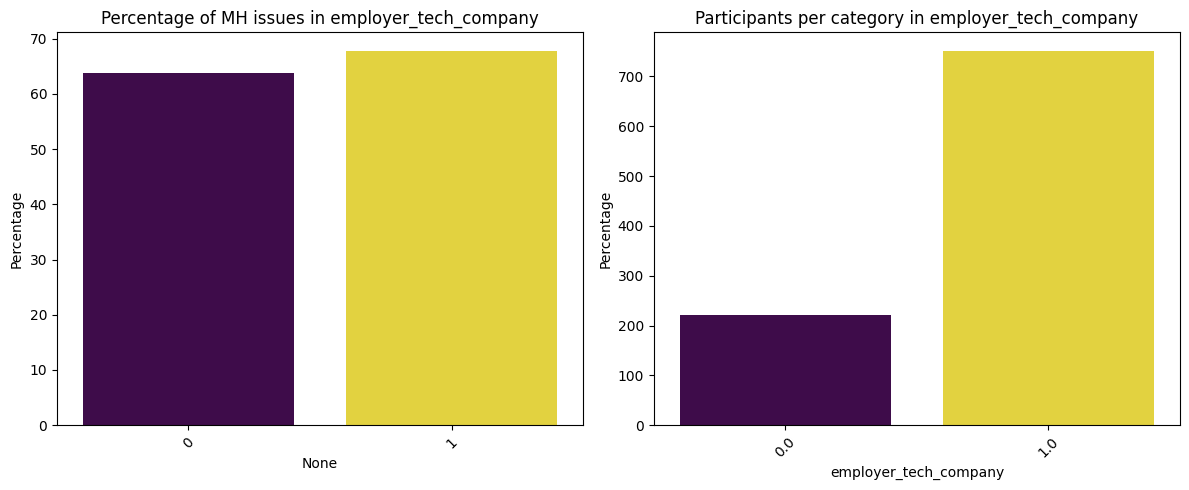

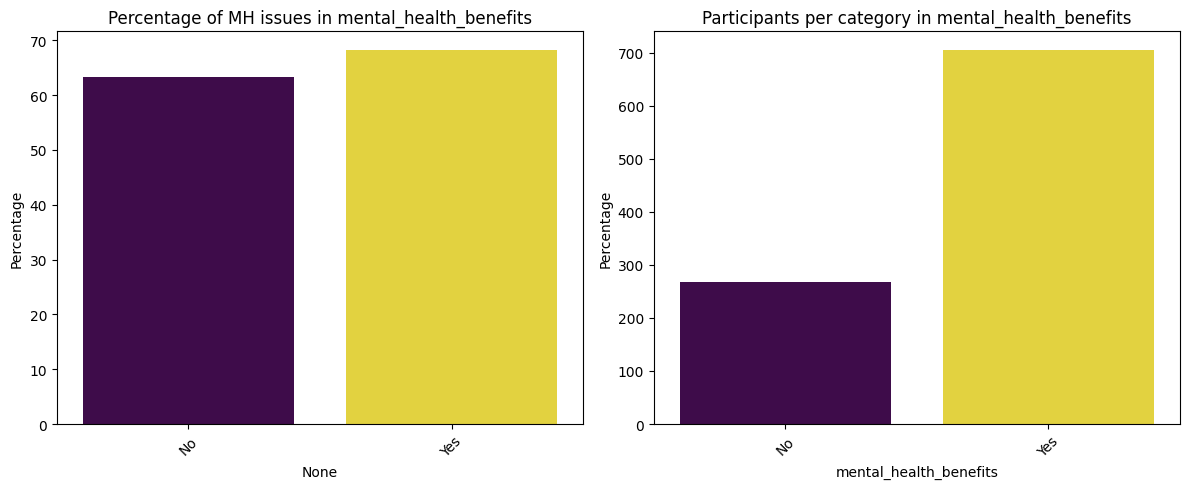

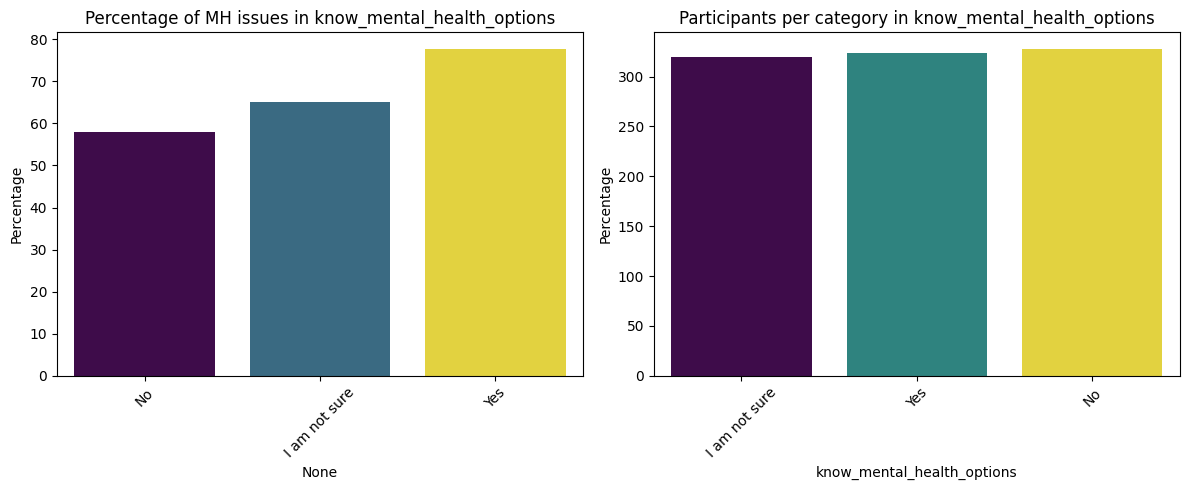

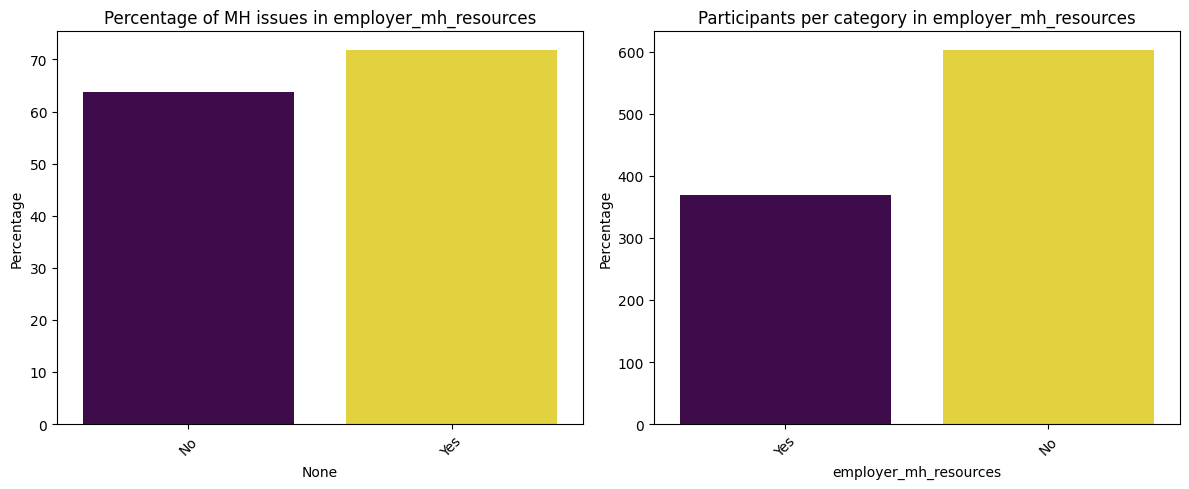

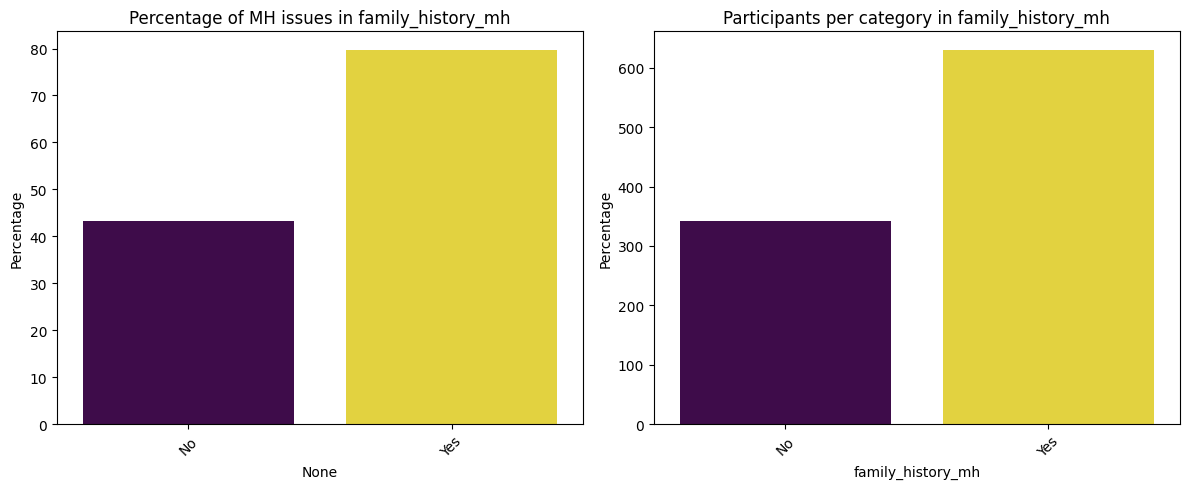

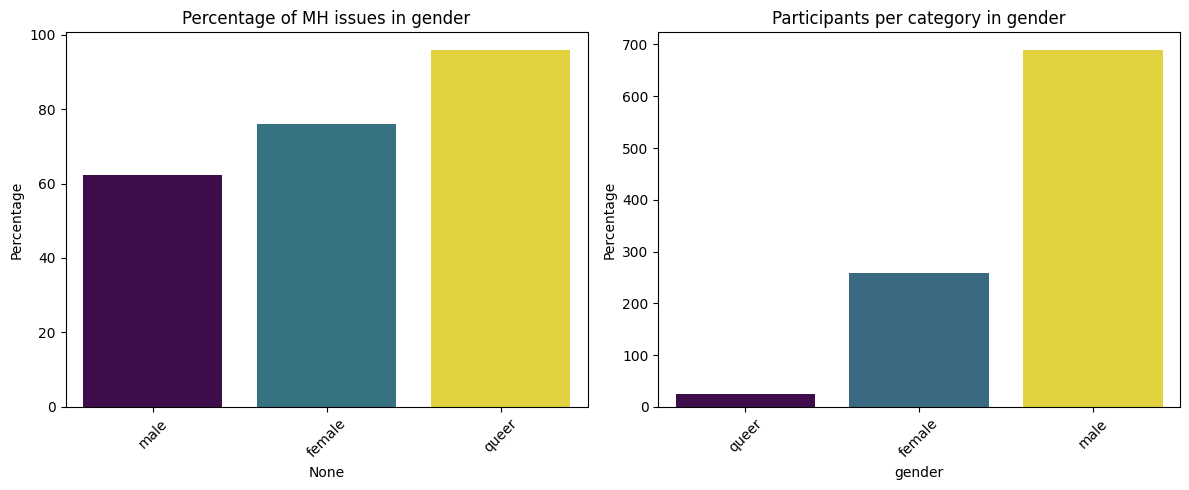

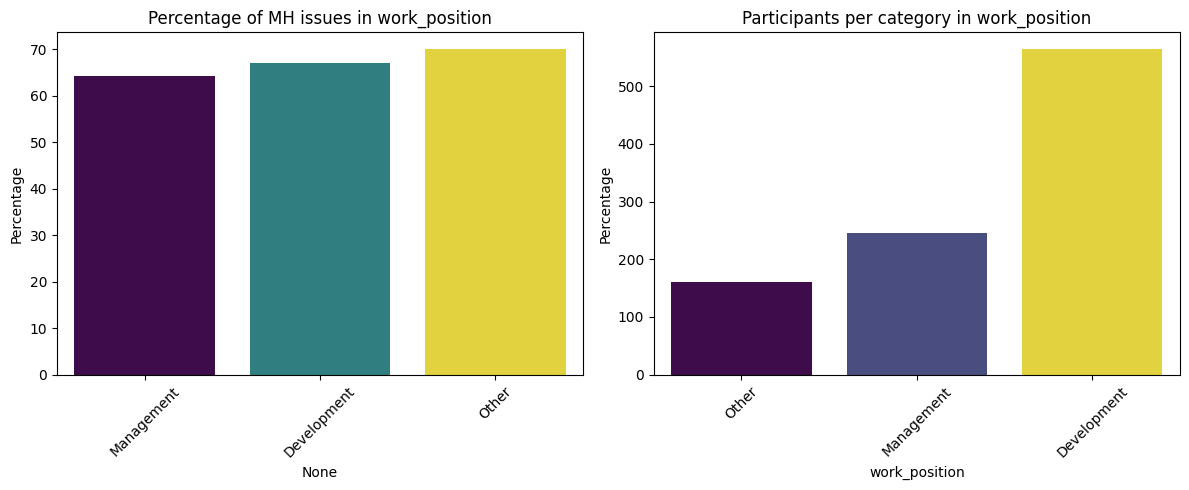

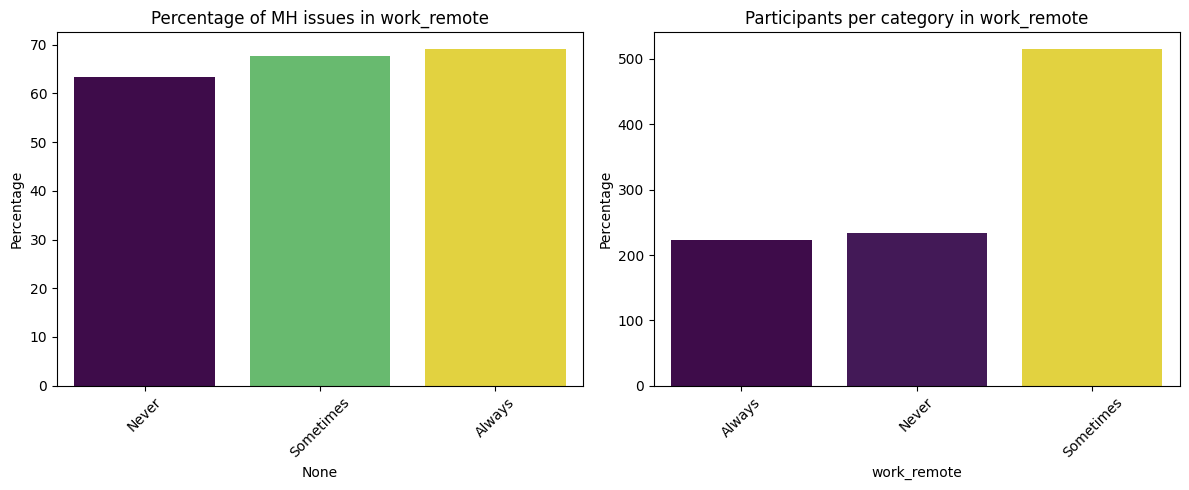

In [48]:
# Create a copy of the data for analysis
stats_analysis_data = study_data.copy()

# Name all columns related to mental health illness
mental_health_cols = [
    'past_mh_disorder',
    'current_mh_disorder',
]

# Create a binary column to store positive answers
stats_analysis_data['positive_mental_health'] = None

# Iterate over the rows and check if there is a positive answer
for index, row in stats_analysis_data.iterrows():
    positive_mental_health = any(row[col] == 'Yes' for col in mental_health_cols)
    stats_analysis_data.at[index, 'positive_mental_health'] = positive_mental_health

# Create a list of columns to analyze
columns = [
    'self_employed',
    'num_employees',
    'employer_tech_company',
    'mental_health_benefits',
    'know_mental_health_options',
    'employer_mh_resources',
    'family_history_mh',
    'gender',
    'work_position',
    'work_remote'
]

# Calculate if mental health issues are overrepresented in relevant columns
for col in columns:
    unique_values = stats_analysis_data[col].value_counts()

    # Create a Series to store the results
    results = pd.Series()
    for value in unique_values.index:
        total = unique_values[value]
        positive = stats_analysis_data[stats_analysis_data[col] == value]['positive_mental_health'].sum()
        percentage = (positive / total) * 100
        results[value] = percentage

    # Sort the results
    results = results.sort_values(ascending=True)
    unique_values = unique_values.sort_values(ascending=True)

    # Set up the figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # First plot
    sns.barplot(ax=axes[0], x=results.index, y=results.values, hue=results.values, palette='viridis', legend=False)
    axes[0].set_title(f'Percentage of MH issues in {col}')
    axes[0].set_ylabel('Percentage')
    axes[0].tick_params(axis='x', rotation=45)

    # Second plot
    sns.barplot(ax=axes[1], x=unique_values.index, y=unique_values.values, hue=unique_values.values, palette='viridis', legend=False)
    axes[1].set_title(f'Participants per category in {col}')
    axes[1].set_ylabel('Percentage')
    axes[1].tick_params(axis='x', rotation=45)

    # Adjust layout for better display
    fig.tight_layout()
    plt.savefig(f'data/plot_images/Stats_{col}.png', bbox_inches='tight')
    plt.show()

# Cluster analysis K-Means Data

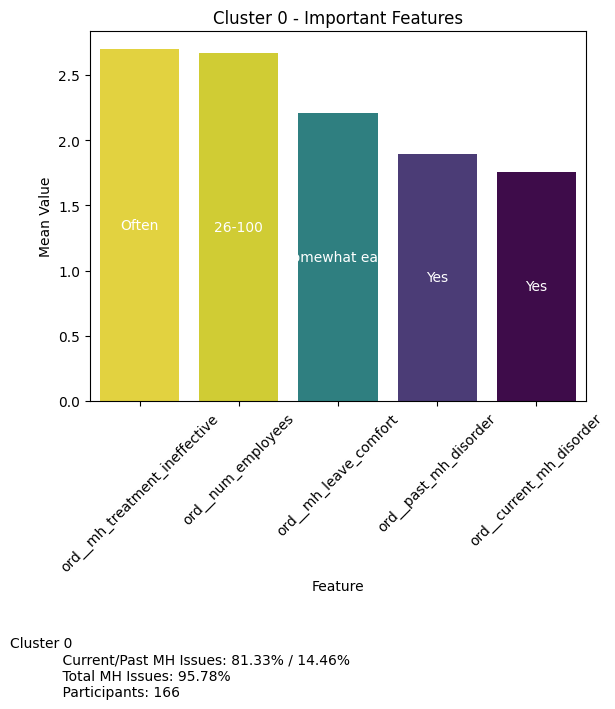

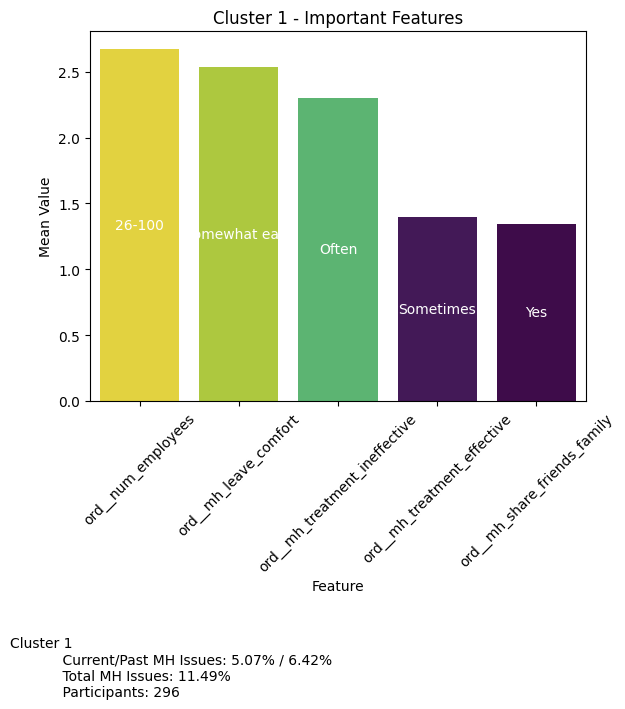

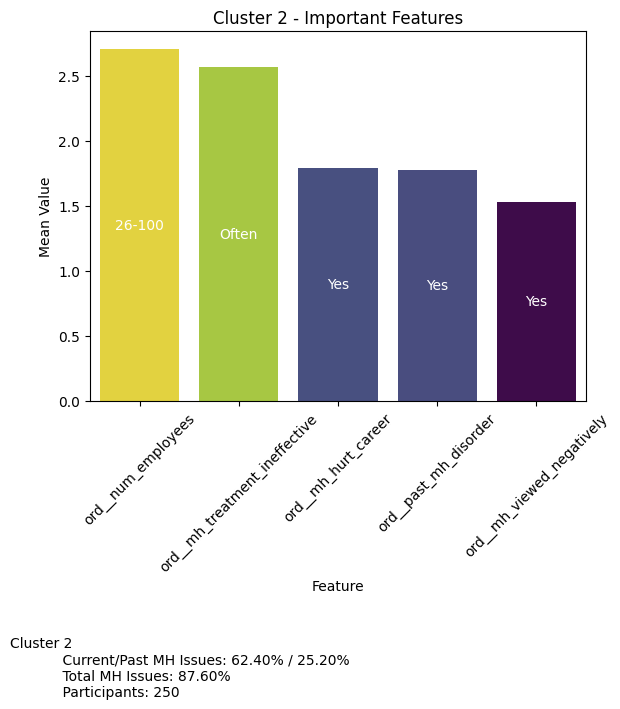

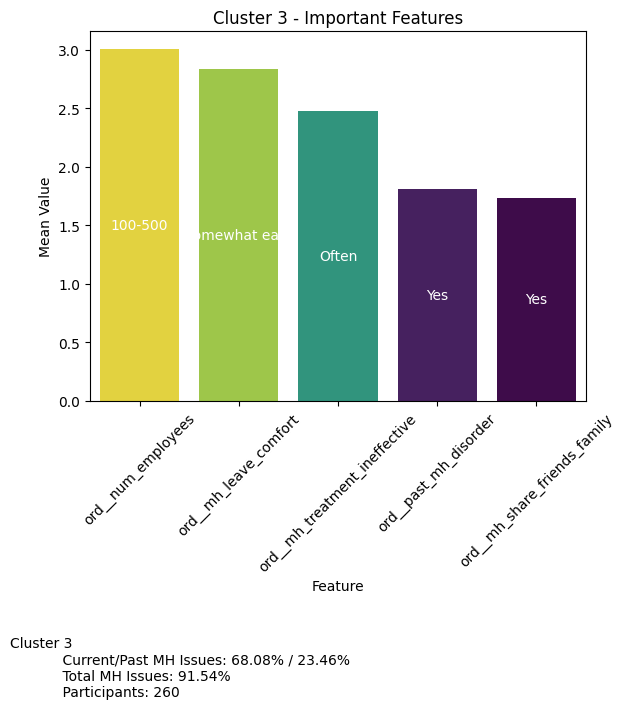

In [49]:
# Create a copy of the data for analysis
plot_cluster_data = kmeans_save_data.copy()

# Compute mean of each feature for each cluster
cluster_centers = plot_cluster_data.groupby('Cluster').mean()

# Get absolute values to identify the most influential features
absolute_cluster_centers = cluster_centers.abs()

# Identify top 5 important features per cluster
important_features_per_cluster = absolute_cluster_centers.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

# Visualize the important features per cluster
for cluster, features in important_features_per_cluster.items():

    # Get the top features for this cluster
    top_features = cluster_centers.loc[cluster, features]
    
    # Plot the barplot for these features
    ax = sns.barplot(x=top_features.index, y=top_features.values, hue=top_features.values, palette='viridis', legend=False)
    plt.title(f'Cluster {cluster} - Important Features')
    plt.ylabel('Mean Value')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)

    # Add mode values as annotations inside the bars
    for i, feature in enumerate(top_features.index):
        
        # Get the mode value for this feature in this cluster
        mode_value = plot_cluster_data[plot_cluster_data['Cluster'] == cluster][feature].mode().iloc[0]

        # Map the numeric mode values back to the original values. Remove 'ord__' prefix
        mode_value = ordinal_mapping[feature.replace('ord__', '')][int(mode_value)]

        # Add the mode value as an annotation inside the bar
        bar_value = top_features.values[i]  # Bar height (mean value)
        ax.text(
            x=i,  # X-coordinate (bar index)
            y=bar_value / 2,  # Y-coordinate (middle of the bar)
            s=mode_value,  # Text displaying mode value
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            fontsize=10,  # Font size
            color='white'  # Text color for readability
        )

    # Get the number of MH issues for this cluster
    current_mh_issues = 0
    past_mh_issues = 0
    total_mh_issues = 0
    for index, row in plot_cluster_data[plot_cluster_data['Cluster'] == cluster].iterrows():
        if row['ord__current_mh_disorder'] == 2:
            current_mh_issues += 1
        elif row['ord__past_mh_disorder'] == 2:
            past_mh_issues += 1
        if row['ord__current_mh_disorder'] == 2 or row['ord__past_mh_disorder'] == 2:
            total_mh_issues += 1

    # Get the number of participants in this cluster
    participants = plot_cluster_data['Cluster'].value_counts().get(cluster, 0)

    # Calculate the percentage of participants with MH issues
    current_mh_issues_percentage = (current_mh_issues / participants) * 100
    past_mh_issues_percentage = (past_mh_issues / participants) * 100
    total_mh_issues_percentage = (total_mh_issues / participants) * 100

    # Add the percentage and participant count as a description at the bottom
    plt.figtext(
        0,  # X-coordinate (center of the figure)
        -0.5,  # Y-coordinate (below the plot)
        f'''Cluster {cluster}
            Current/Past MH Issues: {current_mh_issues_percentage:.2f}% / {past_mh_issues_percentage:.2f}%
            Total MH Issues: {total_mh_issues_percentage:.2f}%
            Participants: {participants}''',
        wrap=True,  # Wrap text if too long
        ha='left',  # Horizontal alignment
        fontsize=10,  # Font size
        color='black',  # Text color
    )
    plt.savefig(f'data/plot_images/KMeans_Cluster_{cluster}_Important_Features.png', bbox_inches='tight')
    plt.show()

# Cluster analysis GMM data

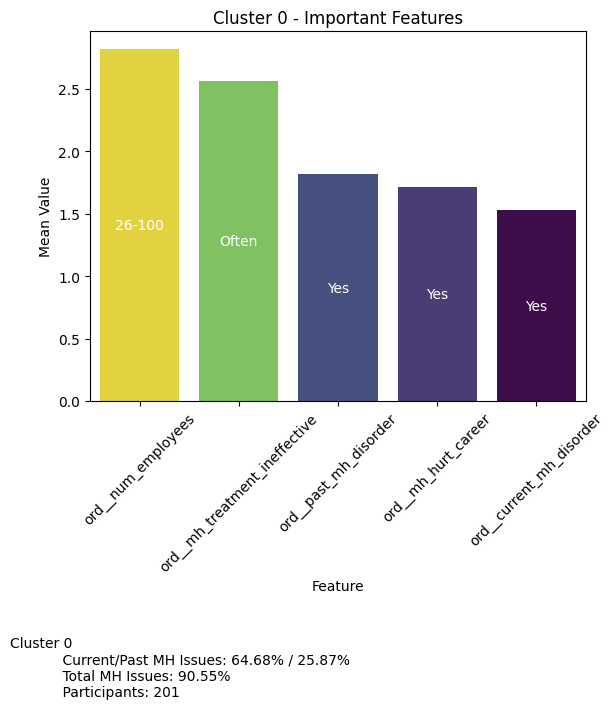

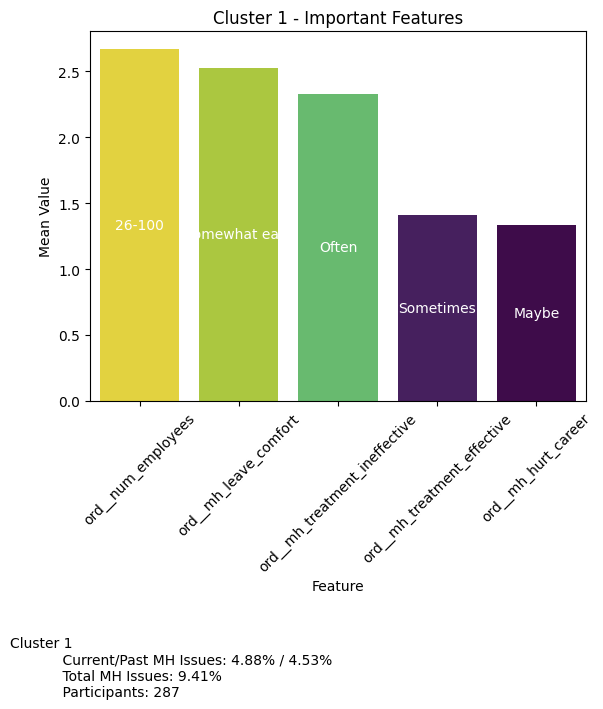

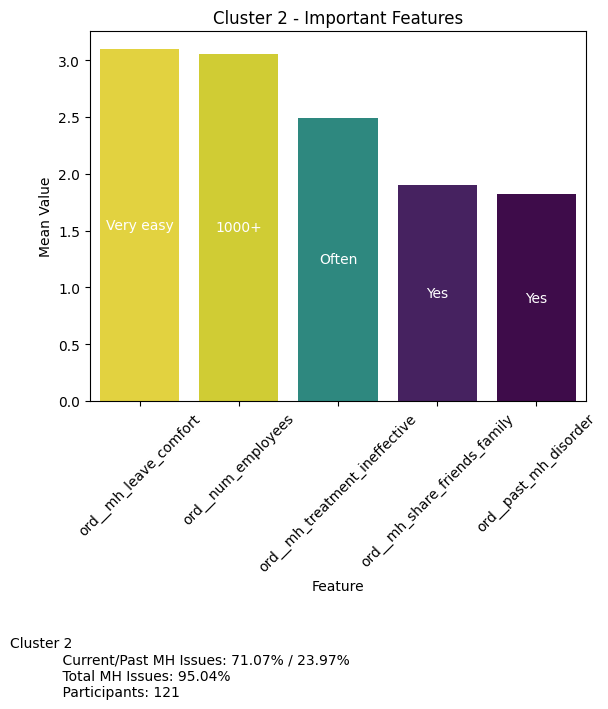

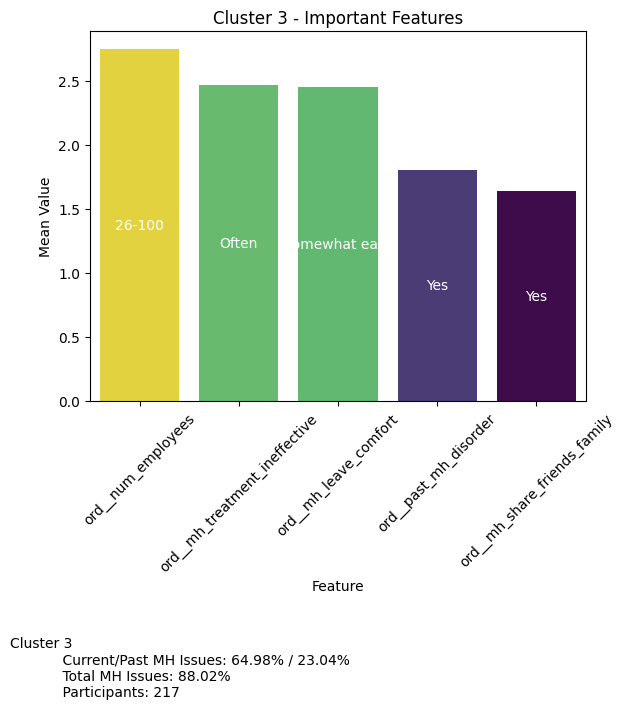

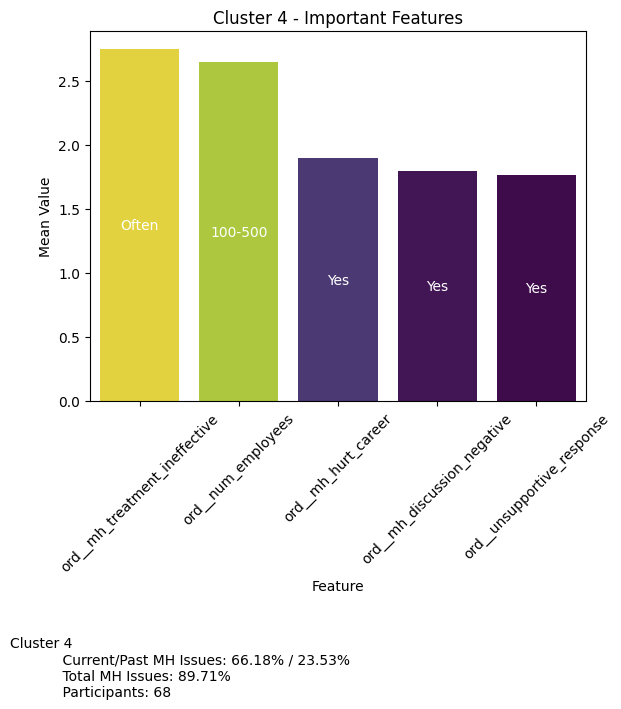

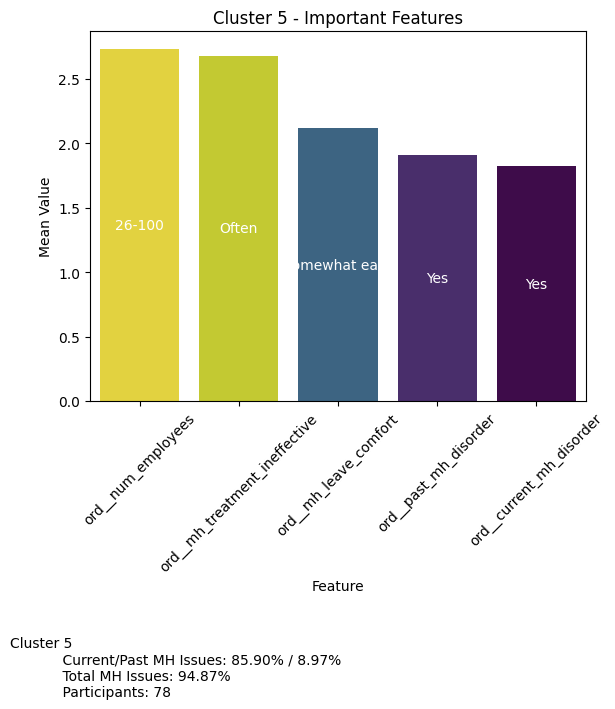

In [50]:
# Create a copy of the data for analysis
plot_cluster_data = gmm_save_data.copy()

# Compute mean of each feature for each cluster
cluster_centers = plot_cluster_data.groupby('Cluster').mean()

# Get absolute values to identify the most influential features
absolute_cluster_centers = cluster_centers.abs()

# Identify top 5 important features per cluster
important_features_per_cluster = absolute_cluster_centers.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

# Visualize the important features per cluster
for cluster, features in important_features_per_cluster.items():

    # Get the top features for this cluster
    top_features = cluster_centers.loc[cluster, features]
    
    # Plot the barplot for these features
    ax = sns.barplot(x=top_features.index, y=top_features.values, hue=top_features.values, palette='viridis', legend=False)
    plt.title(f'Cluster {cluster} - Important Features')
    plt.ylabel('Mean Value')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)

    # Add mode values as annotations inside the bars
    for i, feature in enumerate(top_features.index):
        
        # Get the mode value for this feature in this cluster
        mode_value = plot_cluster_data[plot_cluster_data['Cluster'] == cluster][feature].mode().iloc[0]

        # Map the numeric mode values back to the original values. Remove 'ord__' prefix
        mode_value = ordinal_mapping[feature.replace('ord__', '')][int(mode_value)]

        # Add the mode value as an annotation inside the bar
        bar_value = top_features.values[i]  # Bar height (mean value)
        ax.text(
            x=i,  # X-coordinate (bar index)
            y=bar_value / 2,  # Y-coordinate (middle of the bar)
            s=mode_value,  # Text displaying mode value
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            fontsize=10,  # Font size
            color='white'  # Text color for readability
        )

    # Get the number of MH issues for this cluster
    current_mh_issues = 0
    past_mh_issues = 0
    total_mh_issues = 0
    for index, row in plot_cluster_data[plot_cluster_data['Cluster'] == cluster].iterrows():
        if row['ord__current_mh_disorder'] == 2:
            current_mh_issues += 1
        elif row['ord__past_mh_disorder'] == 2:
            past_mh_issues += 1
        if row['ord__current_mh_disorder'] == 2 or row['ord__past_mh_disorder'] == 2:
            total_mh_issues += 1

    # Get the number of participants in this cluster
    participants = plot_cluster_data['Cluster'].value_counts().get(cluster, 0)

    # Calculate the percentage of participants with MH issues
    current_mh_issues_percentage = (current_mh_issues / participants) * 100
    past_mh_issues_percentage = (past_mh_issues / participants) * 100
    total_mh_issues_percentage = (total_mh_issues / participants) * 100

    # Add the percentage and participant count as a description at the bottom
    plt.figtext(
        0,  # X-coordinate (center of the figure)
        -0.5,  # Y-coordinate (below the plot)
        f'''Cluster {cluster}
            Current/Past MH Issues: {current_mh_issues_percentage:.2f}% / {past_mh_issues_percentage:.2f}%
            Total MH Issues: {total_mh_issues_percentage:.2f}%
            Participants: {participants}''',
        wrap=True,  # Wrap text if too long
        ha='left',  # Horizontal alignment
        fontsize=10,  # Font size
        color='black',  # Text color
    )

    plt.savefig(f'data/plot_images/GMM_Cluster_{cluster}_Important_Features.png', bbox_inches='tight')
    plt.show()